# Dataset 2: Transformer based embedding

## Imports and login

In [1]:
import os, re, json, gc, time

import torch
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer

import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
wnl = WordNetLemmatizer()


from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from huggingface_hub import login, logout

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import numpy as np

from matplotlib import pyplot as plt

### Logging in to HuggingFace, downloading the model and reading the dataset

In [2]:
f = open("../hf_token_read", "r")
hf_token = f.read()
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/alkakumari/.cache/huggingface/token
Login successful


In [3]:
# Download the model and tokenizer
model_path = 'Alibaba-NLP/gte-large-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path) #BertTokenizerFast
model = AutoModel.from_pretrained(model_path, trust_remote_code=True) 

In [4]:
df = pd.read_parquet("../data/measuring-hate-speech.parquet")
df_hatespeech = df[["text", "hatespeech"]]

In [5]:
def keep_english_characters(text):
    return re.sub(r'[^A-Za-z0-9\s.,!?;\'\"#@-]', '', text)

In [6]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower()) #lowercase
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['text'] = df['text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['text'] = df['text'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['text'] = df['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['text'] = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

In [7]:
df_hatespeech['cleaned_text'] = df_hatespeech['text'].apply(keep_english_characters)
df_hatespeech.drop(columns=['text'], inplace=True)
df_hatespeech = df_hatespeech.rename(columns={"cleaned_text": "text"})
df_hatespeech = df_hatespeech.rename(columns={"hatespeech": "class"})
df_hatespeech = df_hatespeech[df_hatespeech['text'].apply(lambda x: len(x.split()) > 5)]
df_hatespeech = clean(df_hatespeech)
df_hatespeech.shape
df_hatespeech

/var/folders/ld/3t5tcvzn12s54qtsr3x3pbj40000gq/T/ipykernel_1041/2871613095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hatespeech['cleaned_text'] = df_hatespeech['text'].apply(keep_english_characters)
/var/folders/ld/3t5tcvzn12s54qtsr3x3pbj40000gq/T/ipykernel_1041/2871613095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hatespeech.drop(columns=['text'], inplace=True)


,class,text
0,0.0,yes indeed sort remind elder lady play part mo...
1,0.0,trans woman read tweet right beautiful
2,2.0,question 4 broad criticize america country fle...
3,0.0,time illegals go back country origin keep free...
4,2.0,starter bend one pink kick as pussy get taste ...
...,...,...
135551,0.0,breakingnews sayyed abdulmalikthe saudi regime...
135552,0.0,million yemeni participate mass rally 13square...
135553,0.0,MENTION MENTION MENTION dictator go people ira...
135554,0.0,million yemeni participate mass rally 13square...


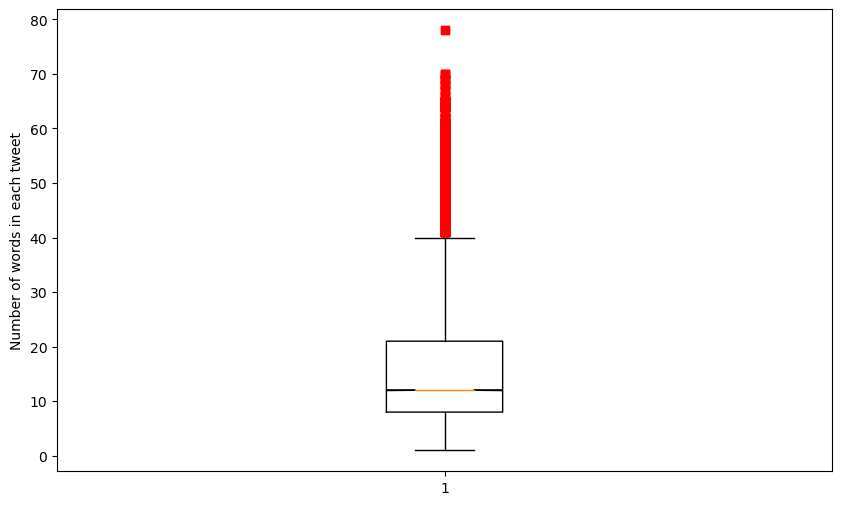

In [8]:
#Plotting boxplot to understand MAX_SEQ_LEN
frequency = []
for i in range(df_hatespeech.shape[0]):
    frequency.append(len(df_hatespeech['text'].iloc[i].split()))
plt.figure(figsize=(10, 6))
plt.boxplot(frequency, 
            notch = True,
            sym = 'rs')
plt.ylabel('Number of words in each tweet')
plt.show()

In [9]:
MAX_SEQ_LEN = 30

In [10]:
X = df_hatespeech.drop(columns=['class'])
Y = df_hatespeech['class']
X = clean(X)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)

## Embedding

### X_train

In [11]:
del df_hatespeech
del f
del hf_token
del stopwords
del wnl
del X
del Y
gc.collect()

3482

In [12]:
token_temp = tokenizer(X_train["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )

In [13]:
embedding_batch_size = 180
num_batches = len(X_train) // embedding_batch_size + 1
print("Number of batches for training:", num_batches)

Number of batches for training: 561


In [15]:
for i in range(num_batches): 
    if i == 0:
        X_train_batch = X_train[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_train_batch = X_train[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_train))
    else:
        X_train_batch = X_train[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_train_batch["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_train_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_train_embeddings = tf.convert_to_tensor(X_train_embeddings.detach().numpy())
    if i == 0:
        tf_X_train_embeddings_concatnated = tf_X_train_embeddings
    else:
        tf_X_train_embeddings_concatnated = tf.concat([tf_X_train_embeddings_concatnated, tf_X_train_embeddings], axis=0)
    del X_train_batch
    del token_temp
    del outputs
    del X_train_embeddings
    del tf_X_train_embeddings
    gc.collect()
    time.sleep(0.5)

Processing batch from 0 to 180
Processing batch from 180 to 360
Processing batch from 360 to 540
Processing batch from 540 to 720
Processing batch from 720 to 900
Processing batch from 900 to 1080
Processing batch from 1080 to 1260
Processing batch from 1260 to 1440
Processing batch from 1440 to 1620
Processing batch from 1620 to 1800
Processing batch from 1800 to 1980
Processing batch from 1980 to 2160
Processing batch from 2160 to 2340
Processing batch from 2340 to 2520
Processing batch from 2520 to 2700
Processing batch from 2700 to 2880
Processing batch from 2880 to 3060
Processing batch from 3060 to 3240
Processing batch from 3240 to 3420
Processing batch from 3420 to 3600
Processing batch from 3600 to 3780
Processing batch from 3780 to 3960
Processing batch from 3960 to 4140
Processing batch from 4140 to 4320
Processing batch from 4320 to 4500
Processing batch from 4500 to 4680
Processing batch from 4680 to 4860
Processing batch from 4860 to 5040
Processing batch from 5040 to 522

In [16]:
tf_X_train_embeddings_concatnated.shape

TensorShape([100804, 1024])

### X_val

In [17]:
num_batches = len(X_val) // embedding_batch_size + 1

In [18]:

for i in range(num_batches): 
    if i == 0:
        X_val_batch = X_val[:embedding_batch_size]
        print("Processing batch from 0 to", embedding_batch_size)
    elif i == num_batches - 1:
        X_val_batch = X_val[embedding_batch_size*i:]
        print("Processing batch from", embedding_batch_size*i, "to", len(X_train))
    else:
        X_val_batch = X_val[embedding_batch_size*i:embedding_batch_size*(i+1)]
        print("Processing batch from", embedding_batch_size*i, "to", embedding_batch_size*(i+1))
    token_temp = tokenizer(X_val_batch["text"].tolist(), 
                            padding='max_length', 
                            truncation=True,
                            max_length=MAX_SEQ_LEN, 
                            return_tensors='pt'
                        )
    outputs = model(**token_temp)
    X_val_embeddings = outputs.last_hidden_state[:, 0]
    tf_X_val_embeddings = tf.convert_to_tensor(X_val_embeddings.detach().numpy())
    if i == 0:
        tf_X_val_embeddings_concatnated = tf_X_val_embeddings
    else:
        tf_X_val_embeddings_concatnated = tf.concat([tf_X_val_embeddings_concatnated, tf_X_val_embeddings], axis=0)
    del X_val_batch
    del token_temp
    del outputs
    del X_val_embeddings
    del tf_X_val_embeddings
    gc.collect()
    time.sleep(2)

Processing batch from 0 to 180
Processing batch from 180 to 360
Processing batch from 360 to 540
Processing batch from 540 to 720
Processing batch from 720 to 900
Processing batch from 900 to 1080
Processing batch from 1080 to 1260
Processing batch from 1260 to 1440
Processing batch from 1440 to 1620
Processing batch from 1620 to 1800
Processing batch from 1800 to 1980
Processing batch from 1980 to 2160
Processing batch from 2160 to 2340
Processing batch from 2340 to 2520
Processing batch from 2520 to 2700
Processing batch from 2700 to 2880
Processing batch from 2880 to 3060
Processing batch from 3060 to 3240
Processing batch from 3240 to 3420
Processing batch from 3420 to 3600
Processing batch from 3600 to 3780
Processing batch from 3780 to 3960
Processing batch from 3960 to 4140
Processing batch from 4140 to 4320
Processing batch from 4320 to 4500
Processing batch from 4500 to 4680
Processing batch from 4680 to 4860
Processing batch from 4860 to 5040
Processing batch from 5040 to 522

In [19]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

## Training

In [26]:
learning_rate = 0.00003

In [20]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = LSTM(500, return_sequences=True)(text_input)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.7)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = simpleRNN(500)(text_input)
    x = dropout(0.8)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(1,vocab_size), name='text_input')
    x = GRU(500)(text_input)
    x = dropout(0.8)(x)
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.3)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['accuracy'])
    return model

In [21]:

def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      mode='min',
                                                      restore_best_weights=True)
      X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
      print(X_train.shape)
      X_val = tf.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, 
            batch_size=batch_size, 
            #class_weight=class_weights,
            callbacks=callback,
            shuffle=True,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
      fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [22]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

(100804, 1, 1024)
Epoch 1/100
788/788 - 19s - loss: 0.6443 - accuracy: 0.7496 - val_loss: 0.5754 - val_accuracy: 0.7767 - 19s/epoch - 24ms/step
Epoch 2/100
788/788 - 17s - loss: 0.5944 - accuracy: 0.7728 - val_loss: 0.5659 - val_accuracy: 0.7799 - 17s/epoch - 22ms/step
Epoch 3/100
788/788 - 17s - loss: 0.5836 - accuracy: 0.7770 - val_loss: 0.5607 - val_accuracy: 0.7828 - 17s/epoch - 21ms/step
Epoch 4/100
788/788 - 17s - loss: 0.5771 - accuracy: 0.7791 - val_loss: 0.5595 - val_accuracy: 0.7831 - 17s/epoch - 22ms/step
Epoch 5/100
788/788 - 16s - loss: 0.5736 - accuracy: 0.7809 - val_loss: 0.5583 - val_accuracy: 0.7833 - 16s/epoch - 20ms/step
Epoch 6/100
788/788 - 16s - loss: 0.5716 - accuracy: 0.7821 - val_loss: 0.5572 - val_accuracy: 0.7850 - 16s/epoch - 20ms/step
Epoch 7/100
788/788 - 17s - loss: 0.5692 - accuracy: 0.7830 - val_loss: 0.5565 - val_accuracy: 0.7861 - 17s/epoch - 21ms/step
Epoch 8/100
788/788 - 15s - loss: 0.5668 - accuracy: 0.7832 - val_loss: 0.5557 - val_accuracy: 0.786

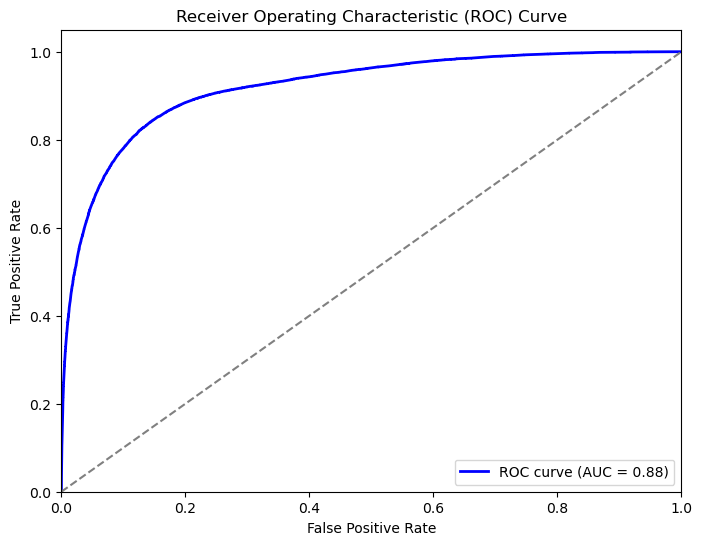

In [23]:
m = model_LSTM(1024)
history_LSTM = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

(100804, 1, 1024)
Epoch 1/100
788/788 - 4s - loss: 0.9543 - accuracy: 0.6776 - val_loss: 0.6352 - val_accuracy: 0.7716 - 4s/epoch - 5ms/step
Epoch 2/100
788/788 - 4s - loss: 0.8032 - accuracy: 0.7211 - val_loss: 0.6079 - val_accuracy: 0.7747 - 4s/epoch - 5ms/step
Epoch 3/100
788/788 - 4s - loss: 0.7568 - accuracy: 0.7282 - val_loss: 0.5965 - val_accuracy: 0.7773 - 4s/epoch - 5ms/step
Epoch 4/100
788/788 - 4s - loss: 0.7276 - accuracy: 0.7361 - val_loss: 0.5862 - val_accuracy: 0.7766 - 4s/epoch - 5ms/step
Epoch 5/100
788/788 - 4s - loss: 0.6997 - accuracy: 0.7443 - val_loss: 0.5805 - val_accuracy: 0.7796 - 4s/epoch - 5ms/step
Epoch 6/100
788/788 - 4s - loss: 0.6792 - accuracy: 0.7494 - val_loss: 0.5813 - val_accuracy: 0.7796 - 4s/epoch - 5ms/step
Epoch 7/100
788/788 - 4s - loss: 0.6636 - accuracy: 0.7532 - val_loss: 0.5772 - val_accuracy: 0.7805 - 4s/epoch - 5ms/step
Epoch 8/100
788/788 - 4s - loss: 0.6492 - accuracy: 0.7583 - val_loss: 0.5739 - val_accuracy: 0.7818 - 4s/epoch - 5ms/ste

/Users/alkakumari/Documents/hate_speech_detection/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


197/197 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7860
Validation Accuracy:  [0.561677098274231, 0.7860402464866638]


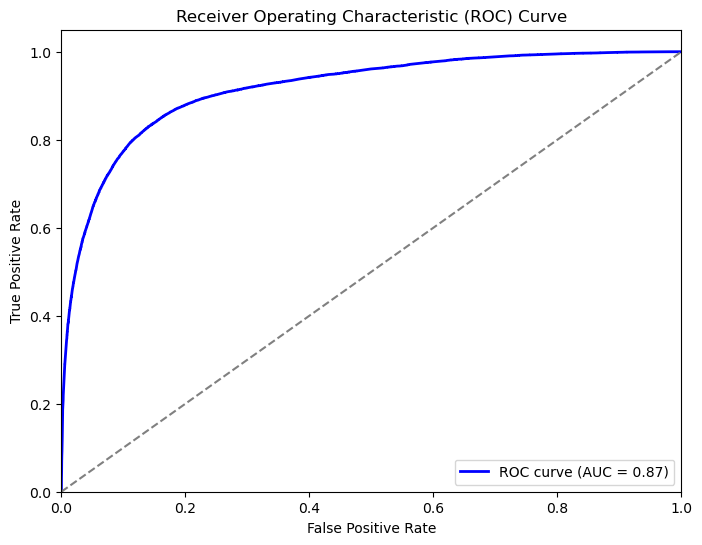

In [28]:
m = model_RNN(1024, input_length=MAX_SEQ_LEN)
history_RNN = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 

(100804, 1, 1024)
Epoch 1/100
788/788 - 9s - loss: 0.6931 - accuracy: 0.7257 - val_loss: 0.5850 - val_accuracy: 0.7735 - 9s/epoch - 12ms/step
Epoch 2/100
788/788 - 9s - loss: 0.6171 - accuracy: 0.7645 - val_loss: 0.5750 - val_accuracy: 0.7764 - 9s/epoch - 11ms/step
Epoch 3/100
788/788 - 9s - loss: 0.6013 - accuracy: 0.7710 - val_loss: 0.5706 - val_accuracy: 0.7784 - 9s/epoch - 11ms/step
Epoch 4/100
788/788 - 9s - loss: 0.5927 - accuracy: 0.7742 - val_loss: 0.5677 - val_accuracy: 0.7794 - 9s/epoch - 11ms/step
Epoch 5/100
788/788 - 9s - loss: 0.5870 - accuracy: 0.7755 - val_loss: 0.5657 - val_accuracy: 0.7814 - 9s/epoch - 12ms/step
Epoch 6/100
788/788 - 9s - loss: 0.5827 - accuracy: 0.7767 - val_loss: 0.5637 - val_accuracy: 0.7817 - 9s/epoch - 12ms/step
Epoch 7/100
788/788 - 8s - loss: 0.5800 - accuracy: 0.7778 - val_loss: 0.5624 - val_accuracy: 0.7820 - 8s/epoch - 11ms/step
Epoch 8/100
788/788 - 9s - loss: 0.5774 - accuracy: 0.7787 - val_loss: 0.5620 - val_accuracy: 0.7838 - 9s/epoch - 

/Users/alkakumari/Documents/hate_speech_detection/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


197/197 [==============================] - 1s 4ms/step - loss: 0.5523 - accuracy: 0.7892
Validation Accuracy:  [0.5523310303688049, 0.7892147302627563]


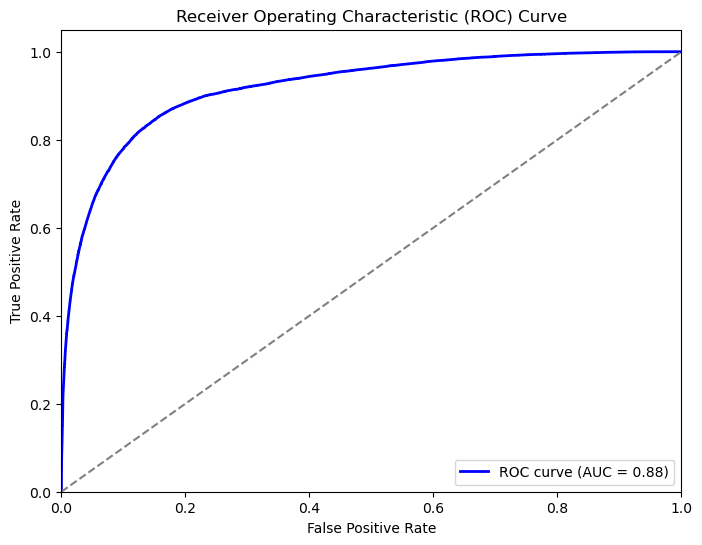

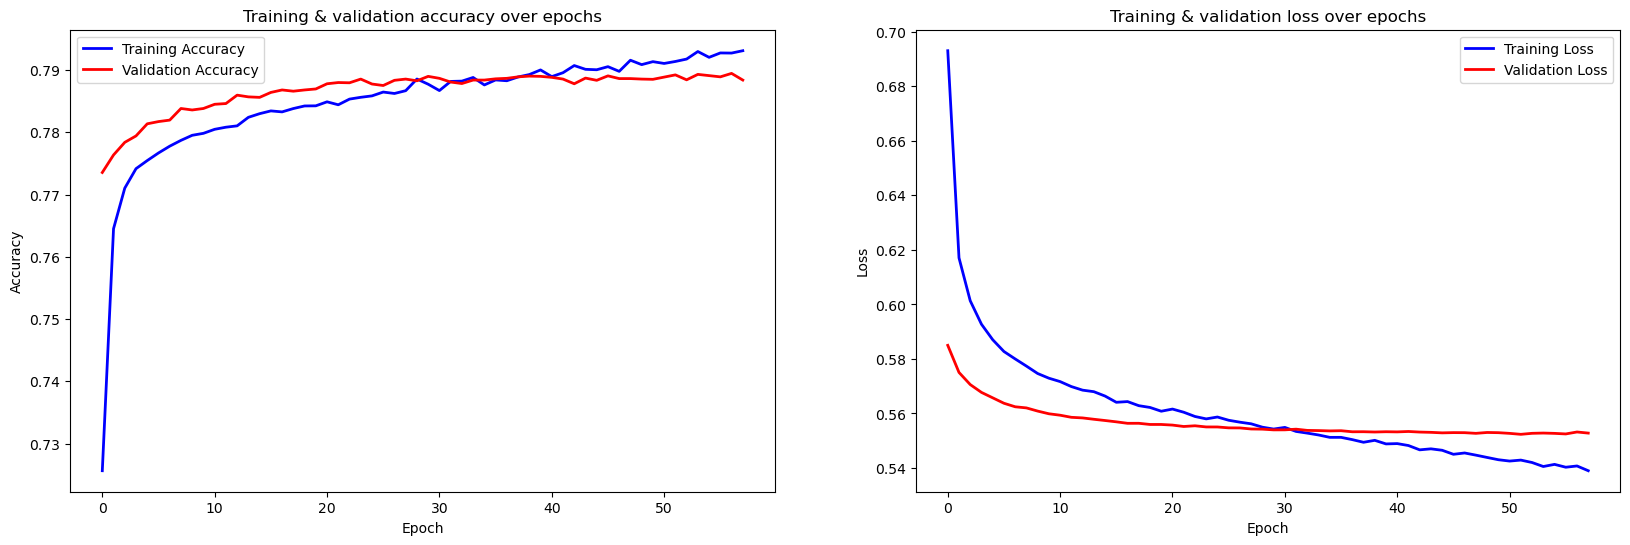

In [34]:
m = model_GRU(1024, input_length=MAX_SEQ_LEN)
history_GRU = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 
evaluate_model(history_GRU)

(100804, 1, 1024)
Epoch 1/100
788/788 - 6s - loss: 0.0772 - accuracy: 0.6688 - val_loss: 0.0565 - val_accuracy: 0.7682 - 6s/epoch - 7ms/step
Epoch 2/100
788/788 - 4s - loss: 0.0610 - accuracy: 0.7536 - val_loss: 0.0546 - val_accuracy: 0.7737 - 4s/epoch - 5ms/step
Epoch 3/100
788/788 - 3s - loss: 0.0579 - accuracy: 0.7646 - val_loss: 0.0534 - val_accuracy: 0.7766 - 3s/epoch - 4ms/step
Epoch 4/100
788/788 - 4s - loss: 0.0562 - accuracy: 0.7699 - val_loss: 0.0527 - val_accuracy: 0.7793 - 4s/epoch - 5ms/step
Epoch 5/100
788/788 - 4s - loss: 0.0553 - accuracy: 0.7726 - val_loss: 0.0525 - val_accuracy: 0.7800 - 4s/epoch - 5ms/step
Epoch 6/100
788/788 - 3s - loss: 0.0546 - accuracy: 0.7747 - val_loss: 0.0522 - val_accuracy: 0.7801 - 3s/epoch - 4ms/step
Epoch 7/100
788/788 - 4s - loss: 0.0542 - accuracy: 0.7753 - val_loss: 0.0520 - val_accuracy: 0.7816 - 4s/epoch - 5ms/step
Epoch 8/100
788/788 - 4s - loss: 0.0537 - accuracy: 0.7776 - val_loss: 0.0519 - val_accuracy: 0.7818 - 4s/epoch - 5ms/ste

/Users/alkakumari/Documents/hate_speech_detection/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


197/197 [==============================] - 0s 1ms/step - loss: 0.0504 - accuracy: 0.7880
Validation Accuracy:  [0.05043359100818634, 0.7879846096038818]


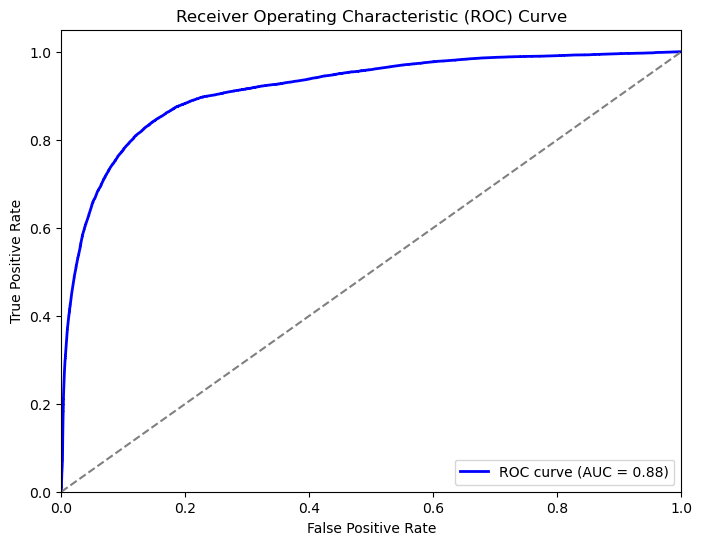

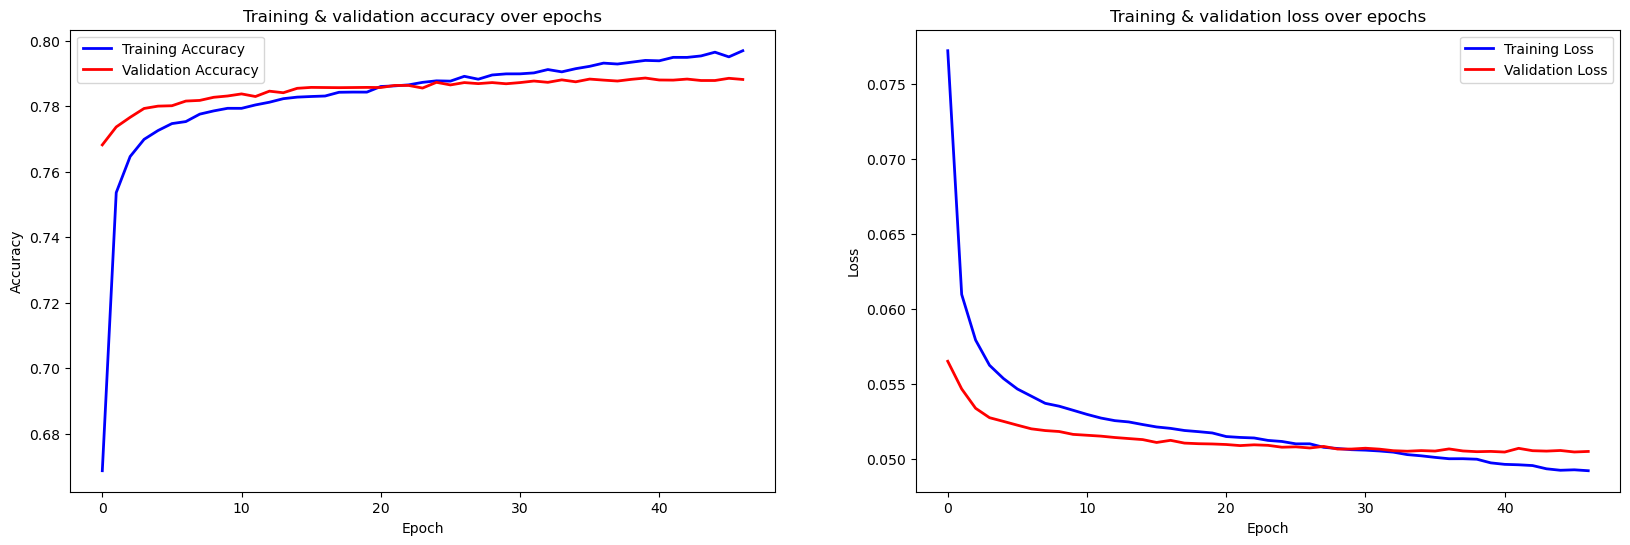

In [37]:
m = novel_model(1024, input_length=MAX_SEQ_LEN, learning_rate=learning_rate)
history_novel = train(m, tf_X_train_embeddings_concatnated, Y_train_encoded, tf_X_val_embeddings_concatnated, Y_val_encoded, epochs=100, batch_size=128) 
evaluate_model(history_novel)